In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from scipy import interpolate

import jax
# jax.config.update("jax_enable_x64", True
import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn
import jax.tree_util as jtu
import diffrax
import equinox as eqx

import sys
sys.path.append("/home/michael/Code/optax/")
sys.path.append("NeuralODE/DDFA_NODE/")
sys.path.insert(0, './utils/fnn/')
import optax
from ddfa_node.tde import embed_data, takens_embedding, convolutional_embedding
from ddfa_node.utils_data_preparation import change_trial_length, split_data
from ddfa_node import phaser, jax_utils


%load_ext autoreload
%autoreload 2

In [3]:

data_loc = "data/Modelingandanalysis-latest/"
files = glob.glob(data_loc + "/**/*K0.csv", recursive=True)
df = pd.read_csv(files[0])
df["Subject"] = 0
for idx, file in enumerate(files[1:]):
    df1 = pd.read_csv(files[0])
    df1["Subject"] = idx + 1
    df = pd.concat((df, df1))
    
df = df[["hip_flexion_r", "hip_flexion_l", "knee_angle_r", "knee_angle_l", "ankle_angle_r", "ankle_angle_l", "Subject"]]
window_length = 30
polyorder = 5
feats = ["hip_flexion_l", "knee_angle_l", "ankle_angle_l", "hip_flexion_r",  "knee_angle_r", "ankle_angle_r"]
n_subjects = len(df["Subject"].unique())
total_steps = len(df)
data = np.zeros((n_subjects, total_steps // n_subjects, len(feats)))
for subject in range(n_subjects):
    data[subject, :, :] = savgol_filter(df[df["Subject"] == subject][feats].to_numpy(), window_length=window_length, polyorder=polyorder, axis=0)

In [5]:
# data2 = np.load("../../Julia/data/human_data.npy")[:, 150:-150, :]
# data2 = (data2 - data2.mean(axis=1)[:, None, :]) / data2.std(axis=1)[:, None, :]
# for trial in range(data2.shape[0]):
#     data2[trial, :, :] = savgol_filter(data2[trial], window_length=window_length, polyorder=polyorder, axis=0)
# data = np.concatenate([change_trial_length(data, data2.shape[1], skip=data2.shape[1]), data2])

In [3]:
window_length = 80
polyorder = 5
data = np.load("/home/michael/Synology/Desktop/Data/Julia/data/VDP_SDEs.npy")[:, 1500:, :][:, :, :]
data = (data - data.mean(axis=1)[:, None, :]) / data.std(axis=1)[:, None, :]
for trial in range(data.shape[0]):
    data[trial, :, :] = savgol_filter(data[trial], window_length=window_length, polyorder=polyorder, axis=0)

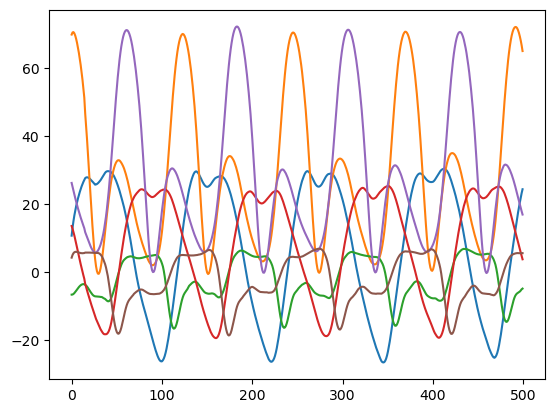

In [6]:
plt.plot(data[0, 0:500])

In [6]:
# data_tde, τ, k = embed_data(data[:, ::5], e_time_threshold=1/np.e)
τ, k = 1, 4
data_tde = takens_embedding(data[:, ::5, :], τ, k)#.astype(jnp.float32)
# base, max_power = 2, 2
# data_tde = convolutional_embedding(data, base, max_power)

In [252]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(data_tde.reshape(-1, data_tde.shape[-1]))
data_tde = np.array([pca.transform(A) for A in data_tde])
data_tde = (data_tde - data_tde.mean(axis=1)[:, None, :]) / data_tde.std(axis=1)[:, None, :]
data_tde = np.array([savgol_filter(data_tde[idx, :, :], window_length=30, polyorder=4, axis=0) for idx in range(len(data_tde))])

In [253]:
pca.explained_variance_ratio_.cumsum()

array([0.43607508, 0.8659299 , 0.90071091, 0.92681955, 0.95141308,
       0.9651524 ])

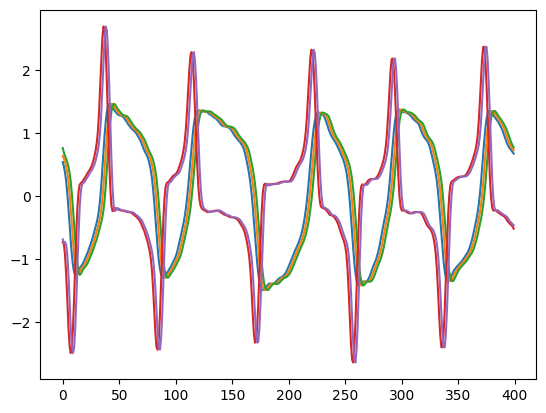

In [7]:
plt.plot(data_tde[0, :400, ::2])

In [8]:
data_tde[:, :, :].shape

(100, 3696, 10)

In [ ]:
# , static_argnames=["timesteps_per_trial", "skip", "t1", "width_size", "hidden_size", "ode_size", "depth", "batch_size", "seed", "print_every", "length_strategy", "lr_strategy", "seeding_strategy", "steps_strategy", "plot","k"
ts, ys, model = jax_utils.train_NODE(
    # model=model,
    data_tde[:, :, :],
    timesteps_per_trial=200,
    t1=2.0,
    width_size=128,
    hidden_size=256,
    ode_size=8,
    depth=2,
    batch_size=64,
    seed=6969,
    lr_strategy=(4e-3, 8e-4, 8e-3),
    steps_strategy=(65000, 30000, 25000),
    length_strategy=(1,),
    skip_strategy=(30, 2,),
    seeding_strategy=(0.5, 0.5,),
    plot=True,
    print_every=1000,
    k=1,
    use_stabilized_node=False,
    linear=False,
    plot_fn=None,
    # k=max_power+2
)

In [169]:
eigs = jnp.linalg.eigvals(np.array(model.func.A))
t = jnp.linspace(0, 2*jnp.pi)
plt.scatter(eigs.real, eigs.imag, c="k")
plt.plot(jnp.cos(t), jnp.sin(t), c="r", lw=1)
plt.axis("equal")

AttributeError: 'Func' object has no attribute 'A'

In [ ]:
ts, ys, model = jax_utils.fine_tune_model(
    model,
    data_tde,
    timesteps_per_trial=1300,
    skip=50,
    t1=13.0,
    width_size=256,
    hidden_size=4,
    ode_size=4,
    depth=2,
    batch_size=256,
    seed=559,
    lr_strategy=(5e-4, 2e-4, 5e-5),
    steps_strategy=(30000, 30000, 30000),
    length_strategy=(0.75, 0.85, 1.0),
    plot=True,
    print_every=1500,
    seeding_strategy=(0.075, 0.075, 0.075),
    k=k+1
)

In [18]:
new_ts = np.linspace(0.0, 40.0, 4000)

In [8]:
seeding_steps = 100
window_length = seeding_steps
polyorder = 5

batch_size = 128
out = np.zeros((ys.shape[0], len(new_ts), ys.shape[2]))
for idx in range(ys.shape[0] // batch_size + 1):
    out[idx*batch_size:idx*batch_size+batch_size] = jax.vmap(model, in_axes=(None, 0))(new_ts, ys[idx*batch_size:idx*batch_size+batch_size, :seeding_steps])
# for idx in range(10):
#     out2 = model.forward(new_ts, out[-seeding_steps:, :])

#     out_discont = jnp.concatenate([out[-seeding_steps*2:-seeding_steps, :], out2[:seeding_steps, :]])
#     interp = savgol_filter(out_discont, window_length, polyorder, axis=0)
#     out = out.at[-2*seeding_steps:-seeding_steps].set(interp[:seeding_steps])
#     out2 = out2.at[:seeding_steps].set(interp[seeding_steps:])
#     out = jnp.concatenate([out[:-seeding_steps, :], out2[:, :]])

NameError: name 'ys' is not defined

In [20]:
seeding_steps = 100
out = jax.vmap(model, in_axes=(None, 0))(new_ts, data_tde[:1, :, :][:, :seeding_steps])

/home/michael/anaconda3/envs/jax/lib/python3.11/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/michael/anaconda3/envs/jax/lib/python3.11/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/michael/anaconda3/envs/jax/lib/python3.11/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


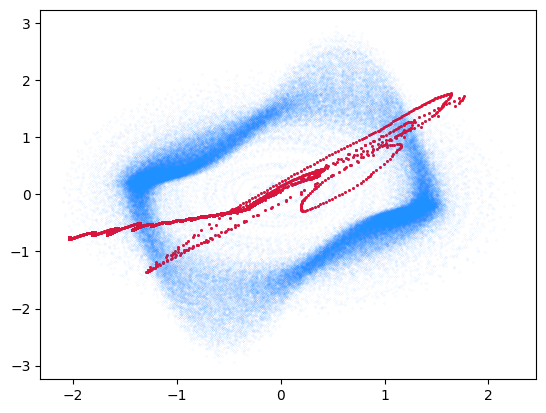

In [21]:
ax = plt.subplot(111)
idx = 50
for idx in range(0, len(data_tde), 3):
    ax.scatter(out[idx, :, 0], out[idx, :, 1], c="crimson", s=0.1, alpha=0.5)
    ax.scatter(data[idx, ::5, 0], data[idx, ::5, 1], c="dodgerblue", s=0.001)

In [166]:
data_tde.shape

(100, 3395, 12)

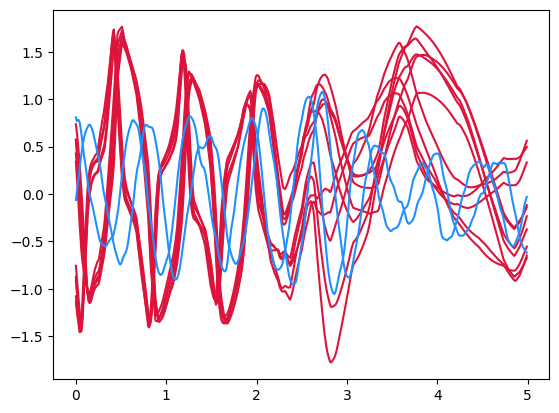

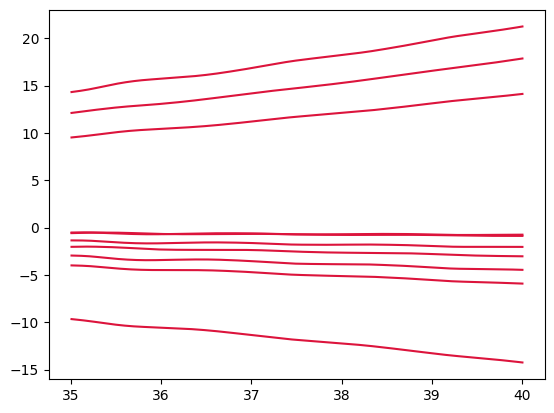

In [22]:
idx = 99
plot_steps = 500

plt.plot(new_ts[:plot_steps], out[idx, :plot_steps, :], c="crimson")
plt.plot(new_ts[:plot_steps], data[:, ::5, :][idx, :plot_steps, :], c="dodgerblue")
plt.show()

plt.plot(new_ts[-plot_steps:], out[idx, -plot_steps:, :], c="crimson")

In [73]:
out2 = model(new_ts, out[-seeding_steps:])

In [200]:
from src.floquet import get_phased_signals
from sklearn.metrics import r2_score
from tqdm.auto import tqdm

def validate_self_gen_data(X_true, X_gen, T=50, N=101):
    trials, _, feats = X_true.shape

    r2s = np.zeros((trials, feats))
    for trial in tqdm(range(trials)):
        all_sigs_true, _ = get_phased_signals(X_true[trial].T, nSegments=N, distance=T)
        mean_sigs_true = all_sigs_true.mean(axis=0)
    
        all_sigs_gen, _ = get_phased_signals(X_gen[trial].T, nSegments=N, distance=T)
        mean_sigs_gen = all_sigs_gen.mean(axis=0)
        for feat in range(feats):
            r2s[trial, feat] = np.max([r2_score(mean_sigs_true[feat], np.roll(mean_sigs_gen[feat], shift)) for shift in range(-N, N, 1)])
    return r2s

In [226]:
r2s = validate_self_gen_data(data[:, ::5], out[:, -2500:, :])

  0%|          | 0/100 [00:00<?, ?it/s]

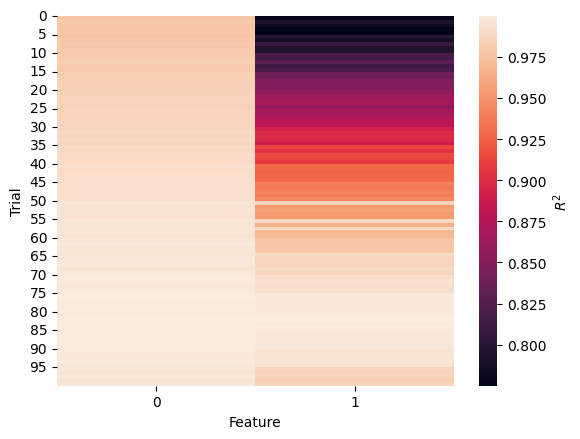

In [228]:
import seaborn as sb
ax = sb.heatmap(r2s) #, vmin=0, vmax=1)
plt.ylabel("Trial")
plt.yticks(range(0, 100, 5), range(0, 100, 5))
plt.xlabel("Feature")
# plt.xticks(range(0, 12, 2), range(0, 12, 2))
ax.collections[0].colorbar.set_label("$R^2$")

In [232]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, GeneralShARK

def solve_sde(model, ts, yi, σ=5e-3):
    t0, t1 = ts[0], ts[-1]
    dt = (ts[1] - ts[0]) / 2
    hidden = jnp.zeros(model.cell.hidden_size)
    for yi_i in yi[::-1]:
        hidden = model.cell(yi_i, hidden)
    y0 = model.hidden_to_ode(hidden)
    
    drift = model.func
    diffusion = lambda t, y, args: jnp.ones(y0.shape[0])*σ*y
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-6, shape=(y0.shape), key=jr.PRNGKey(0))
    terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
    # terms = MultiTerm(ODETerm(drift), diffrax.AbstractTerm(diffusion))
    solver = diffrax.EulerHeun()
    stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-6),
    ts = np.arange(t0, t1, step=dt)
    saveat = SaveAt(ts=ts)

    sol = diffeqsolve(terms, solver, t0, t1, dt0=dt, y0=y0, saveat=saveat, max_steps=None)
    out = jax.vmap(model.ode_to_data)(sol.ys)
    return out

out = jax.vmap(solve_sde, in_axes=(None, None, 0, None))(model, new_ts, data[:, ::5][:, 500:500+seeding_steps], 5e-3)

In [233]:
out.shape

(100, 19998, 2)

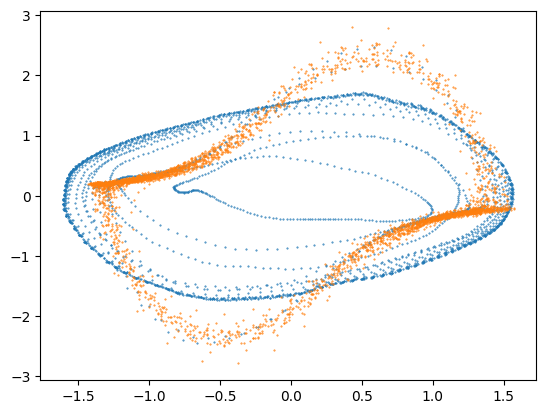

In [237]:
plot_data = out[8, :3000, :]
plt.scatter(plot_data[:, 0], plot_data[:, 1], s=0.2)
plt.scatter(data[:, ::5][8, :3000, 0], data[:, ::5][8, :3000, 1], s=0.2)

In [196]:
np.save("data/VDP_gen_data.npy", out[:, -5000:, ::k+1])

In [ ]:
for idx in range(out.shape[0]):
    plt.plot(new_ts, out[idx, :, ::k+1])
    plt.xlabel("Time (s)")
    plt.ylabel("Feature Magnitude")
    plt.show()

In [204]:
def forward_reinit(model, ts, yi, seeding_steps=100, reinit=500):    
    hidden = jnp.zeros(model.cell.hidden_size)
    
    for yi_i in yi[::-1]:
        hidden = model.cell(yi_i, hidden)
    y0 = model.hidden_to_ode(hidden)
    # y0 = hidden
    total_steps = len(ts) - 1
    steps_per_reinit = reinit
    n_reinits = total_steps // steps_per_reinit + 1
    
    solutions = []
    
    for i in range(n_reinits):
        t0 = ts[i * steps_per_reinit]
        t1 = ts[min((i + 1) * steps_per_reinit, total_steps)]
        
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(model.func),
            diffrax.Tsit5(),
            t0=t0,
            t1=t1,
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-8),
            saveat=diffrax.SaveAt(ts=ts[i * steps_per_reinit:min((i + 1) * steps_per_reinit + 1, total_steps + 1)]),
            max_steps=None,
        )
        
        solutions.append(solution.ys)
        
    
        ys = jnp.concatenate(solutions, axis=0)
        out = jax.vmap(model.ode_to_data)(ys)
        
        hidden = jnp.zeros(model.cell.hidden_size)
        for yi_i in out[::-1][:seeding_steps]:
            hidden = model.cell(yi_i, hidden)
    
        y0 = model.hidden_to_ode(hidden)
        # y0 = hidden
    return out


In [205]:
out = forward_reinit(model, new_ts, ys[0, :seeding_steps], seeding_steps=150, reinit=300)

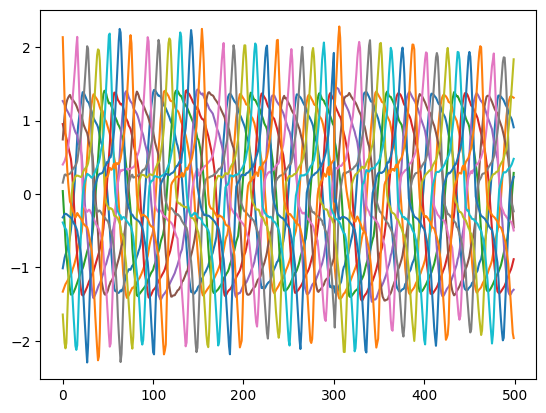

In [209]:
plt.plot(out[:500])

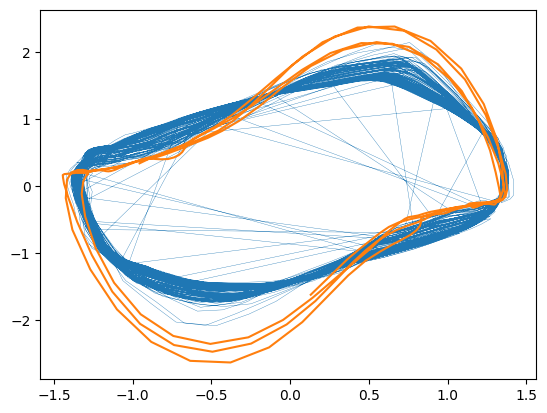

In [207]:
plt.plot(out[:, 0], out[:, k+1], lw=0.25)
plt.plot(ys[0, :, 0], ys[0, :, k+1], lw=1.5)

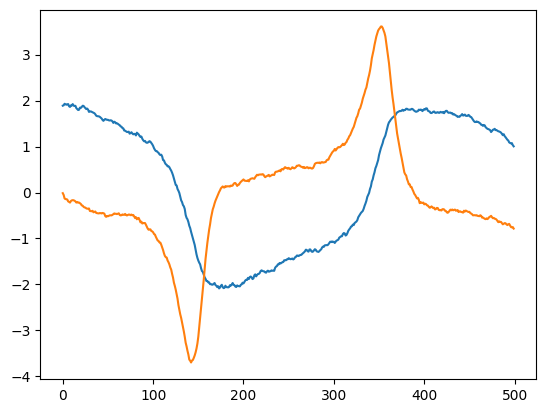

In [329]:
plt.plot(ys[0, :, ::k+1])

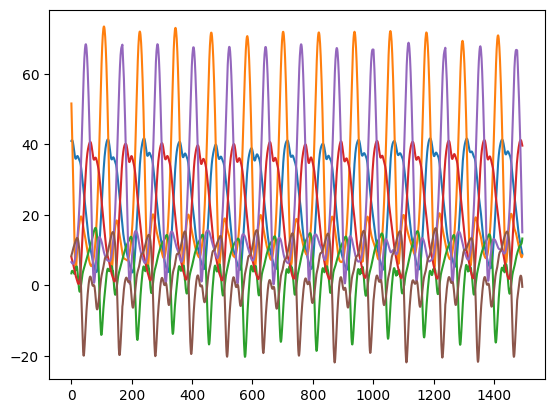

In [62]:
plt.plot(data_tde[0, :, ::k+1])